# 使用scipy.io下载 .mat文件
得到的是字典格式，键值对

In [1]:
import scipy.io as scio
import matplotlib.pyplot as plt
%matplotlib inline

E1 = scio.loadmat('DB2//S1_E1_A1.mat')
E2 = scio.loadmat('DB2//S1_E2_A1.mat')
E3 = scio.loadmat('DB2//S1_E3_A1.mat')

print(E1.keys())
print(E2.keys())
print(E3.keys())


dict_keys(['__header__', '__version__', '__globals__', 'emg', 'acc', 'stimulus', 'glove', 'inclin', 'subject', 'exercise', 'repetition', 'restimulus', 'rerepetition'])
dict_keys(['__header__', '__version__', '__globals__', 'emg', 'acc', 'stimulus', 'glove', 'inclin', 'subject', 'exercise', 'repetition', 'restimulus', 'rerepetition'])
dict_keys(['__header__', '__version__', '__globals__', 'emg', 'acc', 'stimulus', 'force', 'forcecal', 'subject', 'exercise', 'activation', 'repetition', 'restimulus', 'rerepetition'])


# 合并E1，E2，E3数据

(2397479, 12)
(2397479, 1)
[[ 0]
 [ 0]
 [ 0]
 ..., 
 [48]
 [48]
 [48]]


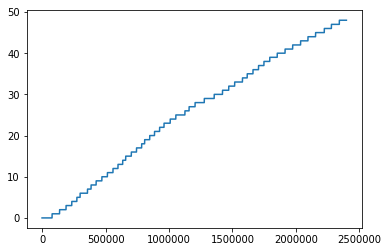

In [2]:
import numpy as np

E1_emg = E1['emg']
E2_emg = E2['emg']
E3_emg = E3['emg']

E1_label = E1['restimulus']
E2_label = E2['restimulus']
E3_label = E3['restimulus']

index1 =[]
for i in range(len(E1_label)):
    if E1_label[i]!=0:
        index1.append(i)
label1 = E1_label[index1,:]
emg1 = E1_emg[index1,:]

index2 =[]
for i in range(len(E2_label)):
    if E2_label[i]!=0:
        index2.append(i)
label2 = E2_label[index2,:]
emg2 = E2_emg[index2,:]

index3 =[]
for i in range(len(E3_label)):
    if E3_label[i]!=0:
        index3.append(i)
label3 = E3_label[index3,:]
emg3 = E3_emg[index3,:]

emg = np.vstack((emg1,emg2,emg3))
label = np.vstack((label1,label2,label3))
label = label-1

print(emg.shape)
print(label.shape)
print(label)

plt.plot(label)

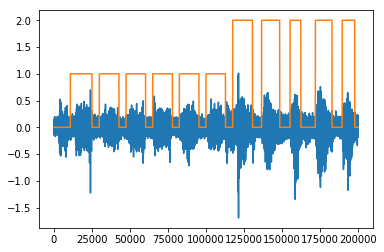

In [3]:
plt.plot(E1_emg[0:200000,5]*20000)
plt.plot(E1_label[0:200000])

# 提取时域特征

### 100ms时间窗，增量窗设为0，1s数据内有10个样本

In [4]:
from feature_utils import *  
import math

featureData=[]
featureLabel = []
classes = 48
timeWindow = 200
strideWindow = 200

for i in range(classes):
    index = [];
    for j in range(label.shape[0]):
        if(label[j,:]==i):
            index.append(j)
    iemg = emg[index,:]
    length = math.floor((iemg.shape[0]-timeWindow)/strideWindow)
    print("class ",i, ",number of sample: ",iemg.shape[0],length)
    
    for j in range(length):
        rms = featureRMS(iemg[strideWindow*j:strideWindow*j+timeWindow,:])
        mav = featureMAV(iemg[strideWindow*j:strideWindow*j+timeWindow,:])
        wl  = featureWL( iemg[strideWindow*j:strideWindow*j+timeWindow,:])
        zc  = featureZC( iemg[strideWindow*j:strideWindow*j+timeWindow,:])
        ssc = featureSSC(iemg[strideWindow*j:strideWindow*j+timeWindow,:])
        featureStack = np.hstack((rms,mav,wl,zc,ssc))
        
        featureData.append(featureStack)
        featureLabel.append(i)
featureData = np.array(featureData)

print(featureData.shape)
print(len(featureLabel))

class  0 ,number of sample:  78701 392
class  1 ,number of sample:  58979 293
class  2 ,number of sample:  50985 253
class  3 ,number of sample:  45065 224
class  4 ,number of sample:  40125 199
class  5 ,number of sample:  25557 126
class  6 ,number of sample:  58155 289
class  7 ,number of sample:  28238 140
class  8 ,number of sample:  39903 198
class  9 ,number of sample:  45174 224
class  10 ,number of sample:  43571 216
class  11 ,number of sample:  44012 219
class  12 ,number of sample:  39313 195
class  13 ,number of sample:  37134 184
class  14 ,number of sample:  23601 117
class  15 ,number of sample:  44281 220
class  16 ,number of sample:  40929 203
class  17 ,number of sample:  40507 201
class  18 ,number of sample:  23523 116
class  19 ,number of sample:  39891 198
class  20 ,number of sample:  37937 188
class  21 ,number of sample:  40019 199
class  22 ,number of sample:  34836 173
class  23 ,number of sample:  48733 242
class  24 ,number of sample:  44250 220
class  25 

# 构造成图像数据

In [5]:
import math
from sklearn.preprocessing import MinMaxScaler
emg = emg*20000

imageData=[]
imageLabel=[]
imageLength=200
classes = 49

for i in range(classes):
    index = [];
    for j in range(label.shape[0]):
        if(label[j,:]==i):
            index.append(j)
            
    iemg = emg[index,:]
    length = math.floor((iemg.shape[0]-imageLength)/imageLength)
    print("class ",i," number of sample: ",iemg.shape[0],length)
    
    for j in range(length):
        subImage = iemg[imageLength*j:imageLength*(j+1),:]
        imageData.append(subImage)
        imageLabel.append(i)
        
imageData = np.array(imageData)
print(imageData.shape)
print(len(imageLabel))        

# 保存h5文件

In [7]:
import h5py
file = h5py.File('DB2//DB2_S1_feature_200_0.h5','w')  
file.create_dataset('featureData', data = featureData)  
file.create_dataset('featureLabel', data = featureLabel)  
file.close()  

file = h5py.File('DB2//DB2_S1_image_200_0.h5','w')  
file.create_dataset('imageData', data = imageData)  
file.create_dataset('imageLabel', data = imageLabel)  
file.close()  